In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.ticker as ticker
import numpy as np
from matplotlib import pyplot as plt, cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import time
from scipy.fft import fft, fftfreq
from scipy.fft import fft2, fftshift

print(np.__version__)





1.26.4


In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, t_u, x_u, layers, kappa, lt, ut, acts=0):

        self.scale = tf.reduce_max(tf.abs(x_u)) / 2
        x_u2 = x_u / self.scale
        actv = [tf.tanh, tf.sin]

        self.t_u = t_u
        self.x_u = x_u2
        self.datatype = t_u.dtype

        self.lt = lt
        self.ut = ut

        self.layers = layers
        self.kappa = kappa

        # determine the activation function to use
        self.actv = actv[acts]

        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)

        # Create a list including all training variables
        self.train_variables = self.weights + self.biases
        # Key point: anything updates in train_variables will be
        #            automatically updated in the original tf.Variable

        # define the loss function
        self.loss0 = self.scale ** 2
        self.loss = []
        self.loss_0 = self.loss_NN()

        self.optimizer_Adam = tf.optimizers.Adam()

    '''
    Functions used to establish the initial neural network
    ===============================================================
    '''

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)

        for l in range(0, num_layers - 1):
            W = self.MPL_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=self.datatype))
            weights.append(W)
            biases.append(b)
        return weights, biases

    def MPL_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=self.datatype))

    '''
    Functions used to building the physics-informed contrainst and loss
    ===============================================================
    '''

    def neural_net(self, X):
        weights = self.weights
        biases = self.biases

        num_layers = len(weights) + 1
        
        H = 2.0 * tf.math.divide(tf.math.subtract(X, tf.transpose(self.lt)), tf.transpose(tf.math.subtract(self.ut, self.lt))) - 1.0
        
        W = weights[0]
        b = biases[0]
        
        # H = self.actv(tf.add(self.kappa * tf.matmul(H, W), b)) # for scalar kappa value
        H = self.actv(tf.add(tf.matmul(H * self.kappa, W), b)) # for n-dim kappa values

        for l in range(1, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    @tf.function
    # calculate the physics-informed loss function
    def loss_NN(self):
        self.x_pred = self.neural_net(self.t_u)
        loss = tf.reduce_mean(tf.square(self.x_u - self.x_pred))
        return loss

    '''
    Functions used to define ADAM optimizers
    ===============================================================
    '''

    # define the function to apply the ADAM optimizer
    def adam_function(self):
        @tf.function
        def f():
            # calculate the loss
            loss_norm = self.loss_NN()
            loss_value = loss_norm * self.loss0
            # store loss value so we can retrieve later
            tf.py_function(f.loss.append, inp=[loss_value], Tout=[])

            # print out iteration & loss
            f.iter.assign_add(1)

            str_iter = tf.strings.as_string([f.iter])
            str_loss = tf.strings.as_string([loss_value], precision=4, scientific=True)

            str_print = tf.strings.join(["Mode: Adam", ", Iter: ", str_iter[0],
                                         ", loss: ", str_loss[0]])
            tf.cond(
                f.iter % 100 == 0,
                lambda: tf.print(str_print),
                lambda: tf.constant(True)  # return arbitrary for non-printing case
            )
            return loss_norm

        f.iter = tf.Variable(0)
        f.term = []
        f.loss = []
        return f

    def Adam_optimizer(self, nIter):
        varlist = self.train_variables
        func_adam = self.adam_function()
        for it in range(nIter):
            tf.keras.optimizers.Adam(func_adam, varlist)
            #self.optimizer_Adam.minimize(func_adam, varlist)
        return func_adam

    '''
    Functions used to define L-BFGS optimizers
    ===============================================================
    '''

    # A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    def Lbfgs_function(self, varlist):
        # obtain the shapes of all trainable parameters in the model
        shapes = tf.shape_n(varlist)
        n_tensors = len(shapes)

        # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
        # prepare required information first
        count = 0
        idx = []  # stitch indices
        part = []  # partition indices

        self.start_time = time.time()

        for i, shape in enumerate(shapes):
            n = np.prod(shape)
            idx.append(tf.reshape(tf.range(count, count + n, dtype=tf.int32), shape))
            part.extend([i] * n)
            count += n

        part = tf.constant(part)

        def assign_new_model_parameters(params_1d):
            # A function updating the model's parameters with a 1D tf.Tensor.
            # Sub-function under function of class not need to input self

            params = tf.dynamic_partition(params_1d, part, n_tensors)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                varlist[i].assign(tf.reshape(param, shape))

        @tf.function
        def f(params_1d):
            # A function that can be used by tfp.optimizer.lbfgs_minimize.
            # This function is created by function_factory.
            # Sub-function under function of class not need to input self

            # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
            with tf.GradientTape() as tape:
                # update the parameters in the model
                # this step is critical for self-defined function for L-BFGS
                assign_new_model_parameters(params_1d)
                # calculate the loss
                loss_norm = self.loss_NN()
                loss_value = loss_norm * self.loss0

            # calculate gradients and convert to 1D tf.Tensor
            grads = tape.gradient(loss_norm, varlist)
            grads = tf.dynamic_stitch(idx, grads)

            # store loss value so we can retrieve later
            tf.py_function(f.loss.append, inp=[loss_value], Tout=[])

            # print out iteration & loss
            f.iter.assign_add(1)

            str_iter = tf.strings.as_string([f.iter])
            str_loss = tf.strings.as_string([loss_value], precision=4, scientific=True)

            str_print = tf.strings.join(["Mode: LBFGS", ", Iter: ", str_iter[0],
                                         ", loss: ", str_loss[0]])
            tf.cond(
                f.iter % 3000 == 0,
                lambda: tf.print(str_print),
                lambda: tf.constant(True)  # return arbitrary for non-printing case
            )

            return loss_value, grads

        # store these information as members so we can use them outside the scope
        f.iter = tf.Variable(0)
        f.idx = idx
        f.part = part
        f.shapes = shapes
        f.assign_new_model_parameters = assign_new_model_parameters
        f.loss = []

        return f

    # define the function to apply the L-BFGS optimizer
    def Lbfgs_optimizer(self, nIter, varlist):

        func = self.Lbfgs_function(varlist)

        # convert initial model parameters to a 1D tf.Tensor
        init_params = tf.dynamic_stitch(func.idx, varlist)

        max_nIter = tf.cast(nIter / 3, dtype=tf.int32)

        # train the model with L-BFGS solver
        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func, initial_position=init_params,
            tolerance=1e-11, max_iterations=max_nIter)

        # after training, the final optimized parameters are still in results.position
        # so we have to manually put them back to the model
        func.assign_new_model_parameters(results.position)

        return func

    '''
    Function used for training the model
    ===============================================================
    '''

    def train(self, nIter, idxOpt):
        if idxOpt == 1:
            # mode 1: running the Adam optimization
            func_adam = self.Adam_optimizer(nIter)
            self.loss += func_adam.loss
        elif idxOpt == 2:
            # mode 2: running the Lbfgs optimization
            func_bfgs = self.Lbfgs_optimizer(nIter, self.train_variables)
            self.loss += func_bfgs.loss

    # @tf.function
    def predict(self, t):
        x_p = self.neural_net(t) * self.scale
        return x_p


In [3]:
noise = 0.0        
np.random.seed(234)
tf.random.set_seed(234)

def fun_test(t):
    # customize the function by the user
    # x = (1 - (t**2) / 2) * np.cos(30*(t + 0.5*(t ** 3))) # example 1
    # x = (t ** 3) / (0.01 + t ** 4) # example 2
    x = tf.exp(t) - t - 1 # example 3
    return x

def fun_test2d(t):
    x = (np.sin(2 * t[:, 0] + 1) - 0.5 * t[:, 0])*(1 - t[:, 1] ** 2)
    return x

def fun_(t1, t2):
    return (np.sin(2 * t1 + 1) - 0.5 * t1)*(1 - t2 ** 2)

# Number of train points (total # = Ntrain ** 2)
Ntrain = 21
t1 = np.linspace(-1.05, 1.05, Ntrain)[:, None]
t2 = np.linspace(-1.05, 1.05, Ntrain)[:, None]
xx, yy = np.meshgrid(t1, t2)
t = tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)

t_train = tf.cast(t, dtype=tf.float64)
x_train = fun_test2d(t)
x_train = tf.reshape(x_train, [len(t), 1])

print(t_train.shape)
print(x_train.shape)

# Domain bounds
lt = [t1.min(0)[0], t2.min(0)[0]]
ut = [t1.max(0)[0], t2.max(0)[0]]
lt = tf.convert_to_tensor(lt)
ut = tf.convert_to_tensor(ut)

# Number of test points (total # = N_eval ** 2)
N_eval = 200
t1 = np.linspace(-1, 1, N_eval)[:, None]
t2 = np.linspace(-1, 1, N_eval)[:, None]
xx_eval, yy_eval = np.meshgrid(t1, t2)
tt = tf.stack([tf.reshape(xx_eval, [-1]), tf.reshape(yy_eval, [-1])], axis=1)
t_eval = tf.cast(tt, dtype=tf.float64)
x_eval = fun_test2d(tt)
x_eval = tf.reshape(x_eval, [len(tt), 1])

(441, 2)
(441, 1)


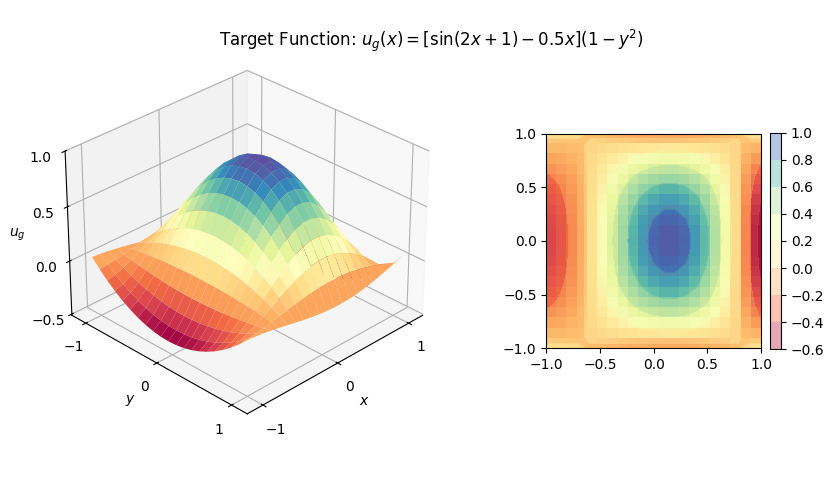

In [4]:
fig = plt.figure(figsize=(10,6), layout='constrained')
fig.suptitle(r'Target Function: $u_g(x) = [\sin(2x + 1) - 0.5x](1 - y^2)$', x=0.55, y=0.85)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
ax = plt.subplot(gs[0], projection='3d')
ax.plot_surface(xx, yy, x_train.numpy().reshape(Ntrain, Ntrain), cmap=cm.Spectral)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-0.5, 0, 0.5, 1])
ax.invert_xaxis()
ax.view_init(elev=30, azim=45)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('$u_g$', rotation=0)
ax.set_box_aspect(None, zoom=0.85)
plt.grid(True)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(x_train.numpy().reshape(Ntrain, Ntrain), extent=[-1, 1, -1, 1], origin='lower', cmap=cm.Spectral)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
contour_filled = plt.contourf(x_train.numpy().reshape(Ntrain, Ntrain), extent=[-1, 1, -1, 1], cmap=cm.Spectral, alpha=0.4)
plt.colorbar(contour_filled, fraction=0.046, pad=0.04)

g = x_train.numpy().flatten()

## Stage 1

In [ ]:
'''
Train a neural network to learn the error of stage 1
'''
# acts = 0 indicates selecting tanh as the activation function
layers = [2, 30, 30, 30, 30, 1]
kappa0 =  [1, 1]
# kappa0 = 1
model_0 = PhysicsInformedNN(t_train, x_train, layers, kappa0, lt, ut, acts=1)
# start the first stage training
model_0.train(5000, 1)     # mode 1 use Adam
model_0.train(20000, 2)    # mode 2 use L-bfgs
x_pred = model_0.predict(t_eval)

error_x = np.linalg.norm(x_eval-x_pred, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x))

In [ ]:
x_pred_plt = x_pred.numpy().reshape(N_eval, N_eval)

fig = plt.figure(figsize=(10,6), layout='constrained')
fig.suptitle(r'First Stage Prediction $u_0$', x=0.55, y=0.85)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
ax = plt.subplot(gs[0], projection='3d')
ax.plot_surface(xx_eval, yy_eval, x_pred_plt, cmap=cm.Spectral)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-0.5, 0, 0.5, 1])
ax.invert_xaxis()
ax.view_init(elev=30, azim=45)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('$u_0$', rotation=0)
ax.set_box_aspect(None, zoom=0.85)
plt.grid(True)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(x_pred_plt, extent=[-1, 1, -1, 1], origin='lower', cmap=cm.Spectral)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
contour_filled = plt.contourf(x_pred_plt, extent=[-1, 1, -1, 1], cmap=cm.Spectral, alpha=0.4)
colorbar = plt.colorbar(contour_filled, fraction=0.046, pad=0.04)
colorbar.formatter.set_powerlimits((0, 0))
colorbar.update_ticks()

In [ ]:
# calculate the error for the first stage
eg_1 = x_train - model_0.predict(t_train)
eps_1 = np.sqrt(1/t_train.shape[0] * sum([i**2 for i in eg_1]))
eg_1_norm = eg_1 / eps_1
g = eg_1_norm.numpy().flatten()

## Stage 2

In [ ]:
# Perform 2D FFT
GG = g.reshape(Ntrain, Ntrain)
G = fft2(GG)
G_shifted = fftshift(G)  # Shift zero frequency component to the center

# Frequency coordinates
N = GG.shape[0]
total_time_range = 2  # From -1 to 1
sample_rate = N / total_time_range
freq_x = fftshift(fftfreq(GG.shape[1], d=1/sample_rate))
freq_y = fftshift(fftfreq(GG.shape[0], d=1/sample_rate))

half_N = N // 2
G_pos = G_shifted[half_N:, half_N:]
freq_x_pos = freq_x[half_N:]
freq_y_pos = freq_y[half_N:]

# Magnitude of the positive frequency FFT
magnitude_spectrum = np.abs(G_pos)
max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
dominant_freq_x = freq_x_pos[max_idx[1]]
dominant_freq_y = freq_y_pos[max_idx[0]]
magnitude = magnitude_spectrum[max_idx] / (N * N)  # Normalize the magnitude

magnitude_spectrum_norm = magnitude_spectrum/np.max(np.max(magnitude_spectrum))
print(f"Sample Rate: {sample_rate} Hz")
print(f"Dominant Frequency X: {dominant_freq_x} Hz")
print(f"Dominant Frequency Y: {dominant_freq_y} Hz")
print(f"Magnitude: {magnitude}")

dominant_freq = np.max([dominant_freq_x, dominant_freq_y])
print(f"Dominant Frequency: {dominant_freq} Hz")

X, Y = np.meshgrid(freq_x_pos, freq_y_pos)

In [ ]:
fig = plt.figure(figsize=(10, 6), layout='constrained')
fig.suptitle(r'First Stage residue $e_1 = u_g - u_0$', x=0.55, y=0.80)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
ax = plt.subplot(gs[0], projection="3d")
ax.plot_surface(xx, yy, eg_1.numpy().reshape(Ntrain, Ntrain), cmap=cm.Spectral)
ax.zaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.zaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='z', style='sci', scilimits=(0,0))
ax.invert_xaxis()
ax.invert_yaxis()
ax.view_init(elev=20, azim=45)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('$e_1$', rotation=0)
ax.set_box_aspect(None, zoom=0.85)
plt.grid(True)

ax = plt.subplot(gs[1])
ax.imshow(eps_1 * g.reshape(Ntrain, Ntrain), extent=[-1, 1, -1, 1], origin='lower', cmap=cm.Spectral)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
contour_filled = plt.contourf(eps_1 * g.reshape(Ntrain, Ntrain), extent=[-1, 1, -1, 1], cmap=cm.Spectral, alpha=0.4)
colorbar = plt.colorbar(contour_filled, fraction=0.046, pad=0.04)
colorbar.formatter.set_powerlimits((0, 0))
colorbar.update_ticks()

# Magnitude spectrum of the 2D FFT
plt.figure(figsize=(6, 4))
plt.pcolormesh(X, Y, magnitude_spectrum_norm, shading='auto', cmap='magma')
plt.colorbar(label='Freq. amp')
plt.title('Frequency domain of $e_1(x, y)$', y=1)
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.xlabel('n')
plt.ylabel('m')

plt.tight_layout()

In [ ]:
# Calculate kappa for Stage 2
if dominant_freq < g.size / (6 * np.pi):
    kappa1 = 2 * np.pi * dominant_freq
else:
    print('Not enough data: Please Increase')

# 2d case with 2 values for kappa
# if dominant_freq_x < g.size / (6 * np.pi) and dominant_freq_y < g.size / (6 * np.pi):
#     kappa1 = [[2 * np.pi * dominant_freq_x], [2 * np.pi * dominant_freq_y]]
#     print('Kappa 1', kappa1)
# else:
#     print('Not enough data: Please Increase')


# increasing training dataset size from 21 to 61 to match plot sizes from Fig 6c
# for max/min freq bins of 15, N = 61
Ntrain = 61
t1 = np.linspace(-1.05, 1.05, Ntrain)[:, None]
t2 = np.linspace(-1.05, 1.05, Ntrain)[:, None]
xx, yy = np.meshgrid(t1, t2)
t = tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)

t_train = tf.cast(t, dtype=tf.float64)
x_train = fun_test2d(t)
x_train = tf.reshape(x_train, [len(t), 1])

lt = [t1.min(0)[0], t2.min(0)[0]]
ut = [t1.max(0)[0], t2.max(0)[0]]
lt = tf.convert_to_tensor(lt)
ut = tf.convert_to_tensor(ut)

eg_1 = x_train - model_0.predict(t_train)
eps_1 = np.sqrt(1/t_train.shape[0] * sum([i**2 for i in eg_1]))
eg_1_norm = eg_1 / eps_1

In [ ]:
'''
Train Neural Network (the error)
'''
layers = [2, 30, 30, 30, 30, 1]
model_1 = PhysicsInformedNN(t_train, eg_1_norm, layers, kappa1, lt, ut, acts=1)
# start the second stage training
model_1.train(5000, 1)    # mode 1 use Adam
model_1.train(20000, 2)   # mode 2 use L-bfgs
eg_1_pred = model_1.predict(t_eval)
# combining the result from first and second stage
x_p = x_pred + eps_1 * eg_1_pred

error_x = np.linalg.norm(x_eval-x_p, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x))

In [ ]:
# calculate the residue for the second stage
eg_2 = x_train - model_0.predict(t_train) - eps_1 * model_1.predict(t_train)
eps_2 = np.sqrt(1/t_train.shape[0] * sum([i**2 for i in eg_2]))
eg_2_norm = eg_2 / eps_2
g = eg_2_norm.numpy().flatten()

## Stage 3

In [ ]:
# Perform 2D FFT
GG = g.reshape(Ntrain, Ntrain)
G = fft2(GG)
G_shifted = fftshift(G)  # Shift zero frequency component to the center

# Frequency coordinates
N = GG.shape[0]
total_time_range = 2  # From -1 to 1
sample_rate = N / total_time_range
freq_x = fftshift(fftfreq(GG.shape[1], d=1/sample_rate))
freq_y = fftshift(fftfreq(GG.shape[0], d=1/sample_rate))

half_N = N // 2
G_pos = G_shifted[half_N:, half_N:]
freq_x_pos = freq_x[half_N:]
freq_y_pos = freq_y[half_N:]


# Magnitude of the positive frequency FFT
magnitude_spectrum = np.abs(G_pos)

max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
dominant_freq_x = freq_x_pos[max_idx[1]]
dominant_freq_y = freq_y_pos[max_idx[0]]
magnitude = magnitude_spectrum[max_idx] / (N * N)  # Normalize the magnitude

magnitude_spectrum_norm = magnitude_spectrum/np.max(magnitude_spectrum)

print(f"Sample Rate: {sample_rate} Hz")
print(f"Dominant Frequency X: {dominant_freq_x} Hz")
print(f"Dominant Frequency Y: {dominant_freq_y} Hz")
print(f"Magnitude: {magnitude}")

dominant_freq = np.max([dominant_freq_x, dominant_freq_y])
print(f"Dominant Frequency: {dominant_freq} Hz")

X, Y = np.meshgrid(freq_x_pos, freq_y_pos)

In [ ]:
fig = plt.figure(figsize=(10, 6), layout='constrained')
fig.suptitle(r'Second Stage residue $e_2 = e_1 - \varepsilon_1 * u_1$', x=0.55, y=0.80)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
ax = plt.subplot(gs[0], projection="3d")
ax.plot_surface(xx, yy, eg_2.numpy().reshape(Ntrain, Ntrain), cmap=cm.Spectral)
ax.zaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.zaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='z', style='sci', scilimits=(0,0))
ax.invert_xaxis()
ax.invert_yaxis()
ax.view_init(elev=20, azim=45)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('$e_2$', rotation=0)
ax.set_box_aspect(None, zoom=0.85)
plt.grid(True)

ax = plt.subplot(gs[1])
ax.imshow(eps_2 * g.reshape(Ntrain, Ntrain), extent=[-1, 1, -1, 1], origin='lower', cmap=cm.Spectral)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
contour_filled = plt.contourf(eps_2 * g.reshape(Ntrain, Ntrain), extent=[-1, 1, -1, 1], cmap=cm.Spectral, alpha=0.4)
colorbar = plt.colorbar(contour_filled, fraction=0.046, pad=0.04)
colorbar.formatter.set_powerlimits((0, 0))
colorbar.update_ticks()

# Magnitude spectrum of the 2D FFT
plt.figure(figsize=(6, 4))
plt.pcolormesh(X, Y, magnitude_spectrum_norm, shading='auto', cmap='magma')
plt.colorbar(label='Freq. amp')
plt.title('Frequency domain of $e_2(x, y)$', y=1)
plt.xlim([0, 15])
plt.ylim([0, 15])
plt.xlabel('n')
plt.ylabel('m')

plt.tight_layout()

In [ ]:
if dominant_freq < g.size / (6 * np.pi):
    kappa2 = 2 * np.pi * dominant_freq
    print('Kappa 2', kappa2)
else:
    print('Not enough data: Please Increase')

# 2d case with 2 values for kappa
# if dominant_freq_x < g.size / (6 * np.pi) and dominant_freq_y < g.size / (6 * np.pi):
#     kappa2 = [[2 * np.pi * dominant_freq_x], [2 * np.pi * dominant_freq_y]]
#     print('Kappa 2', kappa2)
# else:
#     print('Not enough data: Please Increase')

# increasing training dataset size from 61 to 121 to match plots from Fig 6c
# for max/min freq bins of 30, N = 121
Ntrain = 121
t1 = np.linspace(-1.05, 1.05, Ntrain)[:, None]
t2 = np.linspace(-1.05, 1.05, Ntrain)[:, None]
xx, yy = np.meshgrid(t1, t2)
t = tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)

t_train = tf.cast(t, dtype=tf.float64)
x_train = fun_test2d(t)
x_train = tf.reshape(x_train, [len(t), 1])

lt = [t1.min(0)[0], t2.min(0)[0]]
ut = [t1.max(0)[0], t2.max(0)[0]]
lt = tf.convert_to_tensor(lt)
ut = tf.convert_to_tensor(ut)

eg_2 = x_train - model_0.predict(t_train) - eps_1 * model_1.predict(t_train)
eps_2 = np.sqrt(1/t_train.shape[0] * sum([i**2 for i in eg_2]))
eg_2_norm = eg_2 / eps_2

In [ ]:
'''
Train Neural Network (the error)
'''
# (acts = 1 indicates selecting sin as the activation function)
layers = [2, 20, 20, 20, 1]
model_2 = PhysicsInformedNN(t_train, eg_2_norm, layers, kappa2, lt, ut, acts=1)
# start the third stage training
model_2.train(5000, 1)      # mode 1 use Adam
model_2.train(20000, 2)     # mode 2 use L-bfgs
eg_2_pred = model_2.predict(t_eval)
# combining the result from first, second and third stages
x_p = x_pred + eps_1 * eg_1_pred + eps_2 * eg_2_pred

error_x = np.linalg.norm(x_eval-x_p, 2)/np.linalg.norm(x_eval, 2)
print('Error u: %e' % (error_x))

In [ ]:
# calculate the residue for the second stage
eg_3 = x_train - model_0.predict(t_train) - eps_1 * model_1.predict(t_train) - eps_2 * model_2.predict(t_train)
eps_3 = np.sqrt(1/t_train.shape[0] * sum([i**2 for i in eg_3]))
eg_3_norm = eg_3 / eps_3
g = eg_3_norm.numpy().flatten()

## Stage 4

In [ ]:
# Perform 2D FFT
GG = g.reshape(Ntrain, Ntrain)
G = fft2(GG)
G_shifted = fftshift(G)  # Shift zero frequency component to the center

# Frequency coordinates
N = GG.shape[0]
total_time_range = 2  # From -1 to 1
sample_rate = N / total_time_range
freq_x = fftshift(fftfreq(GG.shape[1], d=1/sample_rate))
freq_y = fftshift(fftfreq(GG.shape[0], d=1/sample_rate))

half_N = N // 2
G_pos = G_shifted[half_N:, half_N:]
freq_x_pos = freq_x[half_N:]
freq_y_pos = freq_y[half_N:]

# Magnitude of the positive frequency FFT
magnitude_spectrum = np.abs(G_pos)

max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
dominant_freq_x = freq_x_pos[max_idx[1]]
dominant_freq_y = freq_y_pos[max_idx[0]]
magnitude = magnitude_spectrum[max_idx] / (N * N)  # Normalize the magnitude

magnitude_spectrum_norm = magnitude_spectrum/np.max(np.max(magnitude_spectrum))
print(f"Sample Rate: {sample_rate} Hz")
print(f"Dominant Frequency X: {dominant_freq_x} Hz")
print(f"Dominant Frequency Y: {dominant_freq_y} Hz")
print(f"Magnitude: {magnitude}")

dominant_freq = np.max([dominant_freq_x, dominant_freq_y])
print(f"Dominant Frequency: {dominant_freq} Hz")

X, Y = np.meshgrid(freq_x_pos, freq_y_pos)


In [ ]:
fig = plt.figure(figsize=(10, 6), layout='constrained')
fig.suptitle(r'Third stage residue: $e_3 = e_1 - eps_1*u_1$ - eps_2*u_2', x=0.55, y=0.80)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
ax = plt.subplot(gs[0], projection="3d")
ax.plot_surface(xx, yy, eg_3.numpy().reshape(Ntrain, Ntrain), cmap=cm.Spectral)
ax.zaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.zaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='z', style='sci', scilimits=(0,0))
ax.invert_xaxis()
ax.invert_yaxis()
ax.view_init(elev=20, azim=45)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('$e_3$', rotation=0)
ax.set_box_aspect(None, zoom=0.85)
plt.grid(True)

ax = plt.subplot(gs[1])
ax.imshow(eps_3 * g.reshape(Ntrain, Ntrain), extent=[-1, 1, -1, 1], origin='lower', cmap=cm.Spectral)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
contour_filled = plt.contourf(eps_3 * g.reshape(Ntrain, Ntrain), extent=[-1, 1, -1, 1], cmap=cm.Spectral, alpha=0.4)
colorbar = plt.colorbar(contour_filled, fraction=0.046, pad=0.04)
colorbar.formatter.set_powerlimits((0, 0))
colorbar.update_ticks()

# # Magnitude spectrum of the 2D FFT
plt.figure(figsize=(6, 4))
plt.pcolormesh(X, Y, magnitude_spectrum_norm, shading='auto', cmap='magma')
plt.colorbar(label='Freq. amp')
plt.title('Frequency domain of $e_3(x, y)$')
plt.xlim([0, 30])
plt.ylim([0, 30])
plt.xlabel('n')
plt.ylabel('m')

plt.tight_layout()

In [ ]:
loss = np.array(model_0.loss + model_1.loss + model_2.loss)